**End to end ML project** --Task is to predict median house values in Californian districts, given a number of features from these districts--

In [1]:
# Import a few common modules and guarentee minimum version requirements

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import tarfile
import urllib.request

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

**Download the data**

In [2]:
# Establish path
Download_Root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
Housing_Path = os.path.join("datasets", "housing")
Housing_Url = Download_Root + "datasets/housing/housing.tgz"

# Create a function to fetch the data
def fetch_housing_data(housing_url = Housing_Url, housing_path=Housing_Path):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
# Create a function to load the data
def load_housing_data(housing_path=Housing_Path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# Fetch housing data
fetch_housing_data()

In [4]:
# Load data and take a quick look at data structure
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
"""
--Quick description of the data & check for non-nulls--
Note total_bedrooms has 207 districts missing this feature.
ALL numercial features with exception of one categorical (ocean_proximity)
"""
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# find out what categories exist and how many districts belong to each category
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# Summary statistics of numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


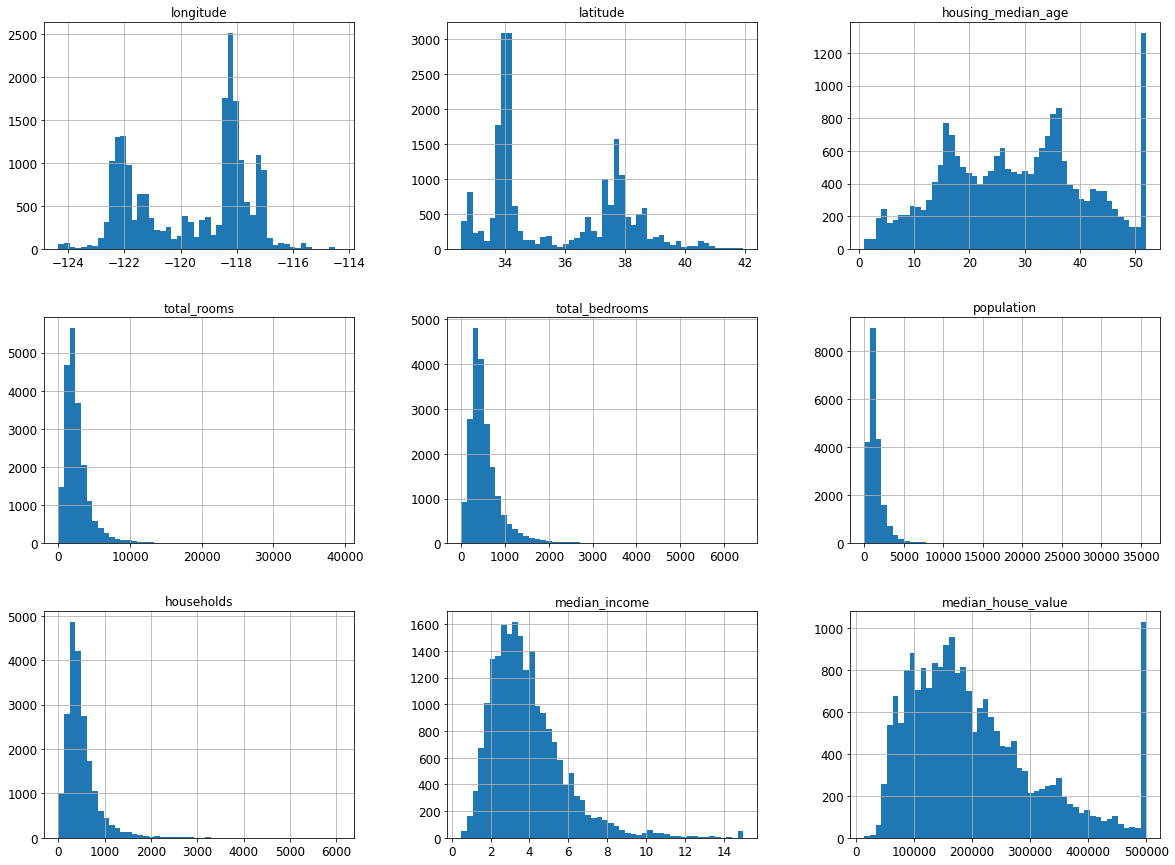

In [8]:
"""
Let's Look at the distribution of the numerical features.
Use .hist() method to plot a histogram for each numerical attribute.
Jupyter's magic command %matplotlib inline tells Matplotlib to 
use Jupyter's own backend

Things of note- 
1. median_income is a preprocessed attribute (scaled and capped) 
   meaning a value of 3 actually refers to about $30,000 USD
2. housing_median_age & median_house_value are also capped. This could
   be an issue as this is the target variable. Need to verify desired downstream 
   output. If precise predictions beyond $500k are needed you could either 
   collect proper labels for capped districts or remove capped districts
   from training and test sets. 
3. Many histograms are tail heavy. May make it harder for some ML algorithms 
   to detect patterns. Look to transform these attributes to more 
   Gaussian shaped distribution further down the line. 
"""

%matplotlib inline
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Create Train/Test Split and set random seed**

In [9]:
# set random generator seed to 42 & test size to 20% of dataset
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [10]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

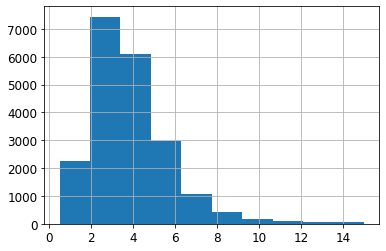

In [11]:
housing['median_income'].hist()

In [12]:
"""
BEWARE of sampling bias. Use Stratified Sampling to avoid Sampling bias.
This will ensure that the test set is representative of the various 
categories of incomes in the whole dataset. A test set generated using 
Random sampling could skew the data and may not be representative of 
the overall population.
Use pd.cut() function to create an income category attribute with 
five categories labeled from 1 to 5
"""
housing['income_category'] = pd.cut(housing['median_income'],
                                   bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1,2,3,4,5])


housing['income_category'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_category, dtype: int64

<AxesSubplot:>

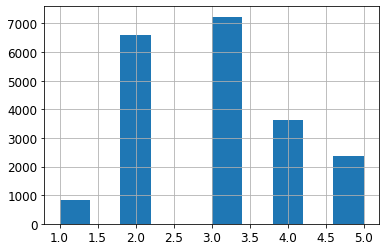

In [13]:
# Review histogram of income_category
housing['income_category'].hist()

In [14]:
"""
Prepare Stratified Sampling based off of income_category attribute
"""
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_category']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
strat_test_set['income_category'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_category, dtype: float64

In [16]:
housing['income_category'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_category, dtype: float64

In [17]:
"""
Review & compare test set generated with Stratified sampling vs. 
test set generated by Random sampling. 
"""

def income_category_proportions(data):
    return data['income_category'].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_proportions = pd.DataFrame({
    'Overall': income_category_proportions(housing),
    'Stratified': income_category_proportions(strat_test_set),
    'Random': income_category_proportions(test_set),
}).sort_index()
compare_proportions['Rand. error%'] = 100 * compare_proportions['Random']/ compare_proportions['Overall']-100
compare_proportions['Strat. error%'] = 100 * compare_proportions['Stratified']/compare_proportions['Overall']-100

In [18]:
"""
Here we see that the test set generated using Stratified Sampling has 
income category proportions nearly identical to those in the full dataset
while the test set generated using Random Sampling is skewed. 
"""

compare_proportions

,Overall,Stratified,Random,Rand. error%,Strat. error%
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [19]:
# Remove income_category attribute so data is back to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_category', axis=1, inplace=True)

**Explore & Visualize Data to Gain Insights**


In [20]:
# Make copy of training set so as to not alter original while exploring
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

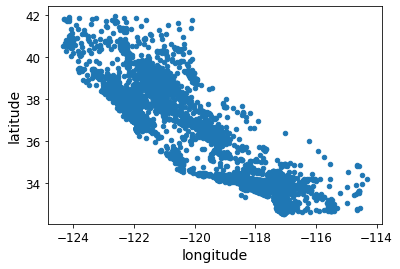

In [21]:
# Create scatter plot based off of longitude & latiitude for visualization 
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

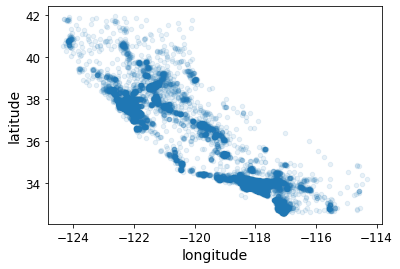

In [22]:
# set alpha to 0.1 to better identify areas with high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

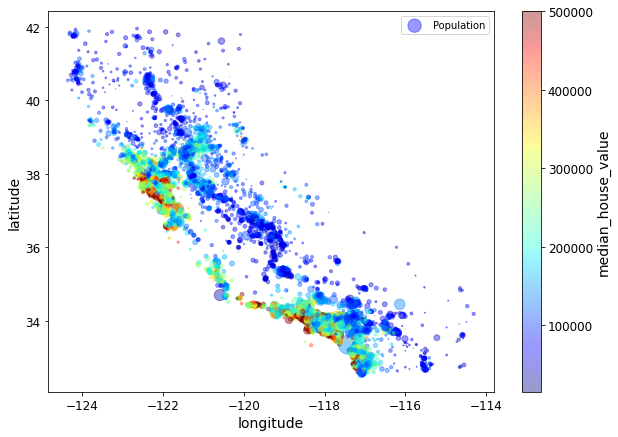

In [23]:
"""
Visualization based on housing prices using jet cmap. Radius of each  
circle represents the districts population. Color represents price with
ranges from low values (blue) to high values (red)
sharex=False used to fix display bug-otherwise x-axis and legend not displayed
"""

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing['population']/100, label='Population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False)
plt.legend()

In [24]:
# Download California image for visualization
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)

Download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading:", filename)
url = Download_root + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

Downloading: california.png


('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x2adec95d850>)

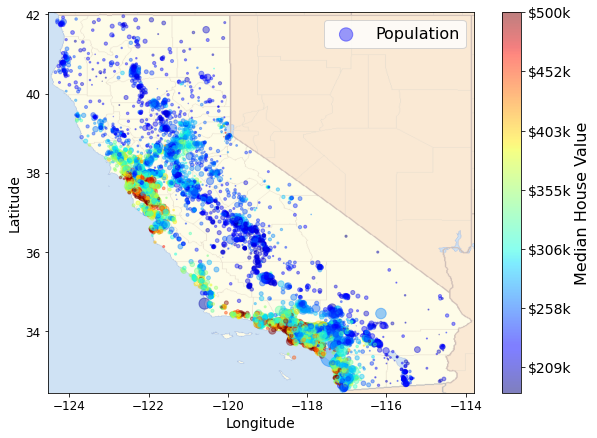

In [25]:
"""
Create visualization combining California image downloaded above with 
jet cmap scatterplot previously shown
"""

import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,7),
                  s=housing['population']/100, label='Population',
                  c='median_house_value', cmap=plt.get_cmap('jet'),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
          cmap=plt.get_cmap('jet'))
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar= plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

**Check for Correlations Among Attributes**

In [26]:
corr_matrix = housing.corr()

In [27]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

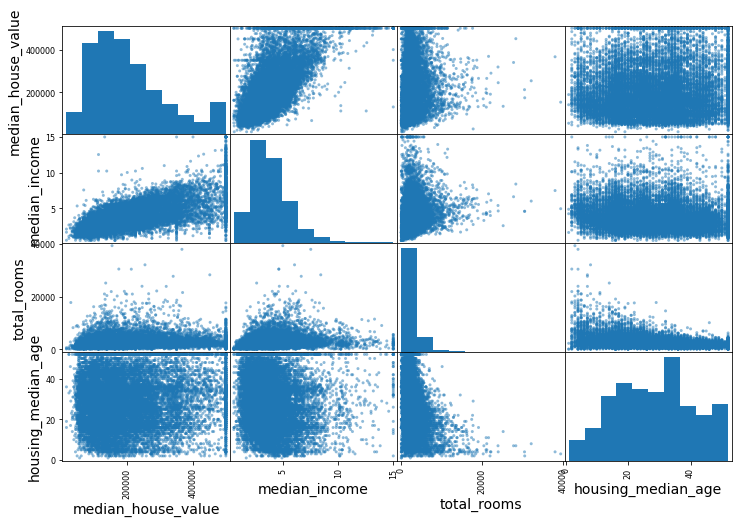

In [28]:
# Create scatter matrix with top 3 features correlated to target attribute
from pandas.plotting import scatter_matrix

features = ['median_house_value', 'median_income', 
            'total_rooms', 'housing_median_age']
scatter_matrix(housing[features], figsize=(12,8))

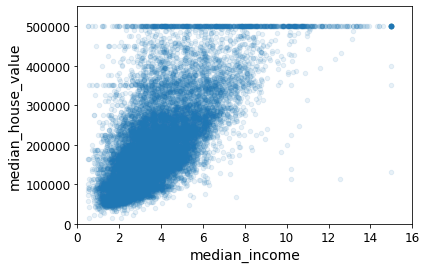

In [29]:
"""
median income w/ a Pearson's r of 0.6872 is the most promising feature
to predict median house value so let's have a closer look
Note: 
    -clear upward trend & data points not too dispersed 
    -Price cap ($500k) mentioned earlier is clearly visible
    -horizontal lines around $450k, $350k, $280k and possibly more below 
    (consider removing corresponding districts before feeding the data to ML
    algos to prevent algorithms from learning to reproduce these data quirks)        
"""
housing.plot(kind='scatter', x='median_income', 
             y='median_house_value', alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

**Experimenting with Feature Engineering**

In [30]:
"""
Combine attributes to engineer new features
-create number of rooms per household rather than total rooms per district
-compare bedrooms to total rooms
-create population per household to get a feel for overall living conditions
"""
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [31]:
"""
Look at correlation matrix again- 
Note: 
    -Negative correlation of bedrooms_per_room with median_house_value. Seems 
     that houses with lower bedroom to room ratio tend to be more exepnsive
    -Rooms_per_household is more informative than total rooms per district.
     More rooms per home means bigger houses. Larger houses are more expensive.
     
Once prototype is up and running, can analyze output to gain more insights and
come back to this exploration step to dig deeper as needed. 
"""

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

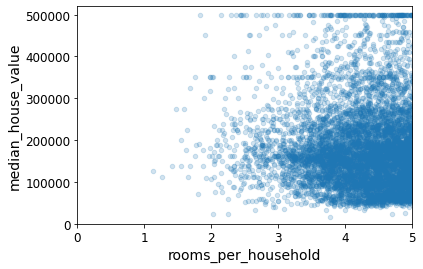

In [32]:
# rooms_per_household scatterplot 
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

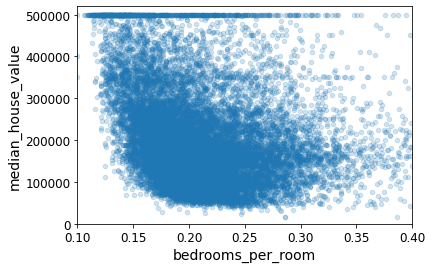

In [33]:
# bedrooms_per_room scatterplot
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.axis([0.1, 0.4, 0, 520000])
plt.show()

In [34]:
# summary statistics for housing dataset including new engineered features
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


**Prepare Data to Better Expose Underlying Data Patterns to ML Algorithms**

In [35]:
"""
Revert back to clean training set. Seperate predictors and target values. 
Note- drop() creates a copy of the data and does not affect strat_train_set
"""
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

**Data Cleaning- Handling Numerical Features**

In [36]:
"""
DATA CLEANING- Most ML algorithms can't work with missing features. We need
to correct this. From before we know total_bedrooms is missing values. 
3 manual options-
    1. Get rid of corresponding districts (use dropna())
    2. Get rid of the whole feature (use drop())
    3. impute mean, median, zero etc. (use .fillna())
    
Manual options get the job done and would work for this simple dataset but 
with a new or updated dataset we don't know if other features will have 
missing values. For reproduceability- Scikit-Learn SimpleImputer works nicely.

"""
#housing.dropna(subset=["total_bedrooms"])    # option 1
#housing.drop("total_bedrooms", axis=1)       # option 2

#median = housing["total_bedrooms"].median()  # option 3
#housing["total_bedrooms"].fillna(median, inplace=True)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')


In [37]:
# median can only be calculated on numerical attributes- drop non-numerical
housing_numerical = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_numerical)

SimpleImputer(strategy='median')

In [38]:
"""
imputer computes mean of each attribute and stores the result in the 
statistics_ instance variable
"""
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [39]:
# Sanity check- manually compute median of each feature and compare w/ above
housing_numerical.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [40]:
"""
We can't be sure that there won't be any missing values in new data after the 
system goes live, so safer to apply the imputer to all numerical features.

Transform the training set, replacing missing values with learned medians
"""
X = imputer.transform(housing_numerical)

In [41]:
# Put resulting NUmPy array back into a Pandas DataFrame
housing_transformed = pd.DataFrame(X, columns=housing_numerical.columns,
                                  index=housing_numerical.index)


In [42]:
# Quick look at DataFrame
housing_transformed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


**Data Cleaning- Handling Text & Categorical Features**

In [43]:
# Note ocean_proximity is a categorical feature not arbitraty text 
housing_cat = housing[['ocean_proximity']]
housing_cat.head(5)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [44]:
"""
Prepocess categorical input feature- Most ML algos prefer to work with 
numbers, so let's convert categories from text to numbers 
using Scikit-Learn's OrdinalEncoder class
"""
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)


In [45]:
# Get list of Categories using categories_ instance
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
"""
As these categories are not ordered we need to create one binary attribute
per category AKA we need to one-hot encode

OneHotEncoder class by default returns a sparse array. Can convert to dense
array using toarray() method OR set sparse=False when creating OneHotEncoder
"""
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_one_hot = cat_encoder.fit_transform(housing_cat)
housing_cat_one_hot


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**Create Custom Transformers to Add Extra Features**

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

# Get column indices dynamically
col_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(col) for col in col_names]

class AddCombinedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
feature_adder = AddCombinedFeatures(add_bedrooms_per_room=False)
housing_extra_features = feature_adder.transform(housing.values)
       

In [48]:
# housing_extra_features outputs a NumPy array. We want a DataFrame.
housing_extra_features = pd.DataFrame(
    housing_extra_features,
    columns=list(housing.columns)+['rooms_per_household',
                                   'population_per_household'],
    index=housing.index)
housing_extra_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


**Feature Scaling ---Transformation Pipelines**

In [49]:
"""
preprocess numerical features

Sklearn MinMaxScaler will normalize data (Values are shifted & rescaled so 
that they are in a range from 0 to 1) i.e. subtract min. value/(max-min)

Sklearn StandardScaler will standarize data (1st substracts the mean, so 
standardized values always have a mean of zero and then divides by the std.
deviation so the resulting distribution has UNIT VARIANCE) 

Note- standardized values are not bound to a specific range which may be a 
problem with some algorithms (Nueral Networks often expect input range 0 to 1)
but are much less effected by outliers.

We will use StandardScaler
"""

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('feature_add', AddCombinedFeatures()),
    ('std_scaler', StandardScaler()), 
])

tran_housing_num = num_pipe.fit_transform(housing_numerical)

In [50]:
# observe dense matrix output
tran_housing_num

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [51]:
"""
Use ColumnTransformer to process numerical and categorical attributes in same
pipeline. 

Note- the numerical pipeline returns a dense matrix and OneHotEncoder returns
a sparse matrix. When mix of sparse and dense matrix output, ColumnTransformer 
estimates the density of the final matrix and if below threshold (default sparse
threshold = 0.3) will return a sparse matrix. This example returns a dense matrix

"""

from sklearn.compose import ColumnTransformer
num_features = list(housing_numerical)
cat_features = ["ocean_proximity"]

pipeline = ColumnTransformer([
    ('numerical', num_pipe, num_features),
    ('categorical', OneHotEncoder(), cat_features)
])

housing_pipeline = pipeline.fit_transform(housing)

In [52]:
housing_pipeline

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
housing_pipeline.shape

(16512, 16)

**Model Selection & Training**

In [54]:
# Kick off with a simple LinearRegression
from sklearn.linear_model import LinearRegression
lin_regression = LinearRegression()
lin_regression.fit(housing_pipeline, housing_labels)

LinearRegression()

In [55]:
# take a small sampling of data to compare predictions vs. actual
some_data = housing.iloc[:10]
some_labels= housing_labels.iloc[:10]
some_data_piped = pipeline.transform(some_data)

print('Prediction:', lin_regression.predict(some_data_piped))
print('\n--------------------------------------------------------\n')
print('Actual:', list(some_labels))

Prediction: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089 206382.40770567 376422.05961781 266569.80764938
 151001.79721225  30119.48436056]

--------------------------------------------------------

Actual: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0, 412300.0, 349600.0, 181300.0, 500001.0]


In [56]:
"""
Review accuracy of predictions using Root Mean Square Error metric

Worried about Outliers and possibly affecting data?- use Mean absolute error
""" 
from sklearn.metrics import mean_squared_error, mean_absolute_error


lin_regression_predictions = lin_regression.predict(housing_pipeline)
lin_mse = mean_squared_error(housing_labels, lin_regression_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(housing_labels, lin_regression_predictions)
print('Root Mean Square Error:',lin_rmse)
print('\nMean Absolute Error:', lin_mae)



Root Mean Square Error: 68627.87390018745

Mean Absolute Error: 49438.66860915801


In [57]:
"""
RMSE (Root Mean Square Error) can also be calulated by calling the function
with squared=False

RMSE of over $68k is not very good. This model is underfitting the training 
data. 

3 main ways to attack underfitting:
    -1. select a more powerful model
    -2. feed better features to the training model
    -3. reduce model contraints *(LR model not regularized- doesn't apply here)
    
We saw that some features are skewed. We could try taking Log of features to 
correct this but trying a more powerful model may offer better bang for buck
"""
lin_regression_predictions = lin_regression.predict(housing_pipeline)
lin_rmse1 = mean_squared_error(housing_labels, 
                              lin_regression_predictions,
                              squared=False)

lin_rmse1

68627.87390018745

In [58]:
"""
DecisionTreeRegressor is a powerful model capable of finding complex 
non-linear relationships in data. 

RMSE of zero! Some call that 5lbs of poop in a 3lb bag. Others call it 
overfitting. One way to better evaluate the Decision Tree Model is to use
train_test_split() function to to split the training set into smaller 
training and validation set and then train model and evaluate. 

We could also use SciKit-Learn's K-fold cross-validation feature.  
"""

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_pipeline, housing_labels)

housing_predictions = tree_reg.predict(housing_pipeline)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                             squared=False)

tree_rmse

0.0

**Cross Validation**

In [59]:
"""
Use K-fold cross-validation to randomly split training set into X (10 in this
case) distinct subsets (folds) 
"""

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_pipeline, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
"""
Code computes -scores before calculating the square root

Scikit-Learn's CV features expect a utility function rather than a 
cost function so the scoring function actually returns a negative value
"""

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [61]:
"""
Compute the same scores for Linear Regression to compare. 

Observe- Decision Tree model is overfitting so badly that it
underperforms the Linear Regression model. 
"""

lin_scores = cross_val_score(lin_regression, housing_pipeline, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180675


**Ensemble Learning Using RandomForestRegressor**

In [62]:
"""
Random Forests work by training many Decision Trees on random subsets
of the features and then averages out their predictions
"""
from sklearn.ensemble import RandomForestRegressor
ran_for_reg = RandomForestRegressor(n_estimators=100,
                                   random_state=42)
ran_for_reg.fit(housing_pipeline, housing_labels)

RandomForestRegressor(random_state=42)

In [63]:
housing_predictions = ran_for_reg.predict(housing_pipeline)
ran_for_mse = mean_squared_error(housing_labels, 
                                 housing_predictions, 
                                 squared=False)
ran_for_mse

18650.698705770003

In [64]:
ran_for_scores = cross_val_score(ran_for_reg, 
                                housing_pipeline,
                                housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
ran_for_RMSE_scores = np.sqrt(-ran_for_scores)
display_scores(ran_for_RMSE_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [65]:
"""
Support Vector Regression using Linear Kernel
"""
from sklearn.svm import SVR

svm_regr = SVR(kernel='linear')
svm_regr.fit(housing_pipeline, housing_labels)
housing_predictions = svm_regr.predict(housing_pipeline)
svm_rmse = mean_squared_error(housing_labels, 
                              housing_predictions,
                             squared=False)
svm_rmse

111095.06635291968

**Save Models using Joblib**

In [66]:
# Save models using JOblib
import joblib

joblib.dump(lin_regression, 'lin_regression.pkl')
joblib.dump(tree_reg, 'DecistionTree.pkl')
joblib.dump(ran_for_reg, 'RandomForest.pkl')
joblib.dump(svm_regr, 'svmRegression.pkl')


['svmRegression.pkl']

**Fine Tuning with Grid Search**

In [67]:
"""
Use GridSearch to search for the best combination of hyperparameter values

We will use RandomForestRegressor for this example

Below- param_grid tells Scikit-Learn to first evaluate 12 combinations (3x4)  
of hyperparameters (n_estimators & max_features) in first dict then try 
6 combinations in the second dict but with bootstrap hyperparameter set to
False (default = True)

This means that we are trying 18 combinations of RandomForestRegressor 
hyperparameter values with cv=5 (will train each model 5 times) for a total 
of 90 (18*5) rounds of training.
"""

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [5, 15, 30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [5,10], 'max_features': [2,4,6]},
]


ran_for_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(ran_for_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_pipeline, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [5, 15, 30]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6],
                          'n_estimators': [5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
# best hyperparameter combination found
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [69]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

**Randomized Search**

In [77]:
"""
RandomizedSearchCV evaluates a given number of random combinations for each 
hyperparameter at each iteration. 
2 main benefits to this approach
    1. running randomized search for 500 iterations will explore 500 different
    values for each hyperparameter rather than just a few values per 
    hyperparameter with GridSearchCV
    2. setting number of iterations allows greater control over computing
    necesities and time/expense allocated to hyperparameter search/tuning
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param = {
    'n_estimators': randint(low=1, high=250),
    'max_features': randint(low=1, high=8),
}

rf_reg = RandomForestRegressor(random_state=42)
rand_searchCV= RandomizedSearchCV(rf_reg, 
                                  param_distributions=param,
                                 n_iter=10,
                                 cv=5,
                                 scoring='neg_mean_squared_error',
                                 random_state=42) 
rand_searchCV.fit(housing_pipeline, housing_labels)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AD97B78850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AD97B78FA0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [78]:
# Observe result of RandomizedSearchCV
rand_search_results = rand_searchCV.cv_results_
for mean_score, params in zip(rand_search_results['mean_test_score'],
                             rand_search_results['params']):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50198.86040811521 {'max_features': 3, 'n_estimators': 215}
50188.60757079441 {'max_features': 3, 'n_estimators': 203}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


In [79]:
# Observe best estimator 
rand_searchCV.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

In [80]:
# Put RandomizedSearchCV results into a Pandas DataFrame to review
pd.DataFrame(rand_searchCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.147288,0.103900,0.167582,0.008755,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.399428e+09,-2.335777e+09,-2.313461e+09,-2.476625e+09,-2.537379e+09,-2.412534e+09,8.434791e+07,1
1,0.635929,0.011817,0.012505,0.006253,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.597812e+09,-2.590195e+09,-2.528533e+09,-2.769539e+09,-2.749759e+09,-2.647168e+09,9.513750e+07,9
2,2.102971,0.092231,0.070427,0.006937,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.569955e+09,-2.512528e+09,-2.438188e+09,-2.656741e+09,-2.671254e+09,-2.569733e+09,8.769636e+07,7
3,0.930588,0.048530,0.024991,0.007670,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.583962e+09,-2.515286e+09,-2.474528e+09,-2.649628e+09,-2.671474e+09,-2.578976e+09,7.554893e+07,8
4,6.798292,0.068304,0.116139,0.007878,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.403611e+09,-2.347924e+09,-2.328235e+09,-2.466494e+09,-2.538690e+09,-2.416991e+09,7.757318e+07,2
5,6.161973,0.089883,0.194364,0.007181,3,215,"{'max_features': 3, 'n_estimators': 215}",-2.549342e+09,-2.437207e+09,-2.405425e+09,-2.591123e+09,-2.616531e+09,-2.519926e+09,8.392809e+07,5
6,6.284969,0.425352,0.214252,0.023251,3,203,"{'max_features': 3, 'n_estimators': 203}",-2.549500e+09,-2.433595e+09,-2.405650e+09,-2.591035e+09,-2.614701e+09,-2.518896e+09,8.416679e+07,4
7,4.407712,0.195978,0.095506,0.008250,5,100,"{'max_features': 5, 'n_estimators': 100}",-2.476178e+09,-2.358022e+09,-2.353633e+09,-2.518094e+09,-2.555806e+09,-2.452346e+09,8.274789e+07,3
8,4.357352,0.047283,0.143272,0.015985,3,150,"{'max_features': 3, 'n_estimators': 150}",-2.553841e+09,-2.457321e+09,-2.421557e+09,-2.600262e+09,-2.618930e+09,-2.530382e+09,7.804472e+07,6
9,0.087498,0.007655,0.003127,0.006253,5,2,"{'max_features': 5, 'n_estimators': 2}",-4.023932e+09,-3.942094e+09,-4.289511e+09,-4.516468e+09,-4.461698e+09,-4.246741e+09,2.294524e+08,10
